In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

model = resnet18(pretrained=True)
model.fc = nn.Linear(512, 100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print("Training the model")
for epoch in range(2):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.4f}")


print("Evaluating the model")
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


100%|██████████| 169M/169M [00:01<00:00, 87.7MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]


Training the model
Epoch 1, Loss: 2.8342
Epoch 2, Loss: 2.1061
Evaluating the model
Test Accuracy: 44.29%


In [ ]:
torch.save(model.state_dict(), "resnet18_cifar100.pth")
print("Model saved to resnet18_cifar100.pth")

Model saved to resnet18_cifar100.pth


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=037b4e47a8c92ece3074f1eba67eb8b283439ff3ecf3b10a19851e8798448509
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
!pip install pillow

  0%|          | 0/1000 [00:00<?, ?it/s]

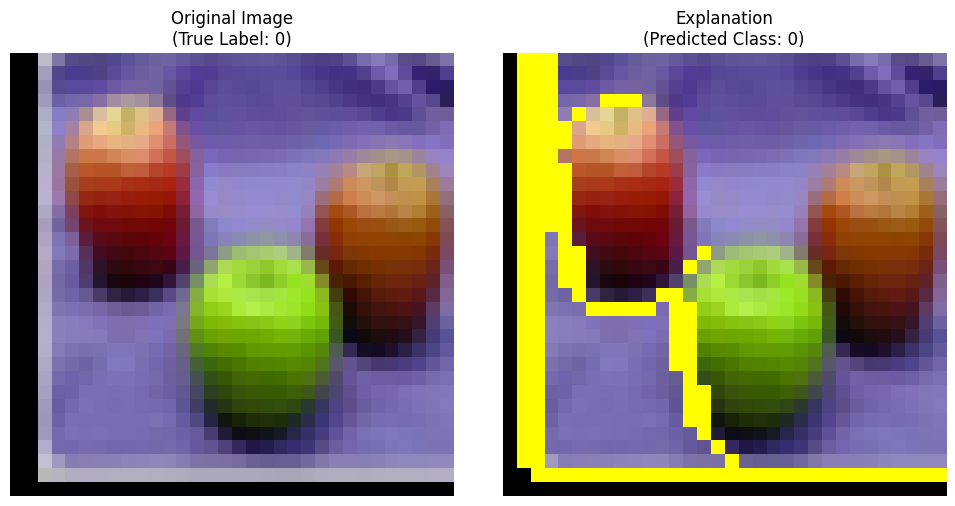

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np

def predict(images):
    images = torch.tensor(images).permute(0, 3, 1, 2).float()
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()

explainer = lime_image.LimeImageExplainer()

image_tensor, label = testset[9]
image_np = image_tensor.numpy().transpose(1, 2, 0)


explanation = explainer.explain_instance(
    image_np,
    predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    hide_rest=False
)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow((image_np * 0.5 + 0.5))  # Denormalize for visualization
axes[0].axis('off')
axes[0].set_title(f"Original Image\n(True Label: {label})")

axes[1].imshow(mark_boundaries(temp * 0.5 + 0.5, mask))
axes[1].axis('off')
axes[1].set_title(f"Explanation\n(Predicted Class: {explanation.top_labels[0]})")

plt.tight_layout()
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

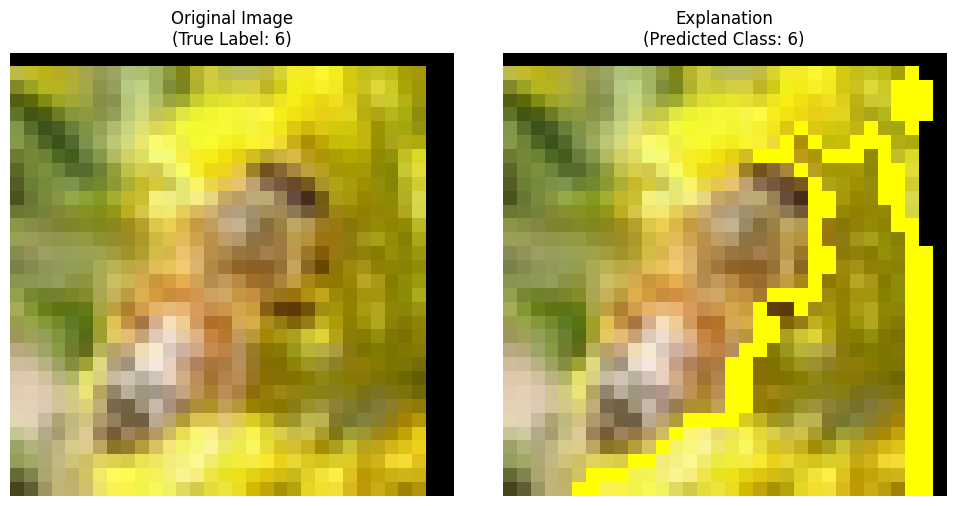

In [ ]:
image_tensor, label = testset[200]
image_np = image_tensor.numpy().transpose(1, 2, 0)


explanation = explainer.explain_instance(
    image_np,
    predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    hide_rest=False
)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow((image_np * 0.5 + 0.5))  # Denormalize for visualization
axes[0].axis('off')
axes[0].set_title(f"Original Image\n(True Label: {label})")

axes[1].imshow(mark_boundaries(temp * 0.5 + 0.5, mask))
axes[1].axis('off')
axes[1].set_title(f"Explanation\n(Predicted Class: {explanation.top_labels[0]})")

plt.tight_layout()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

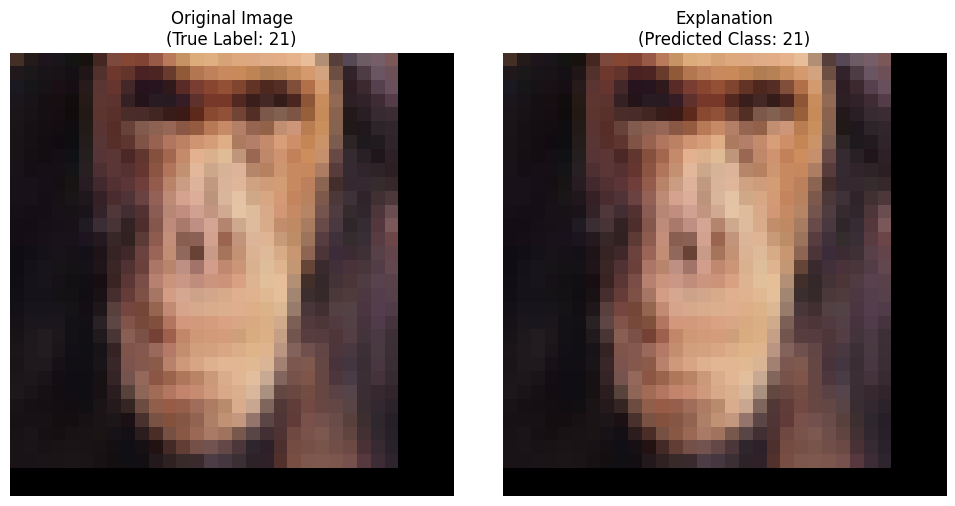

  0%|          | 0/1000 [00:00<?, ?it/s]

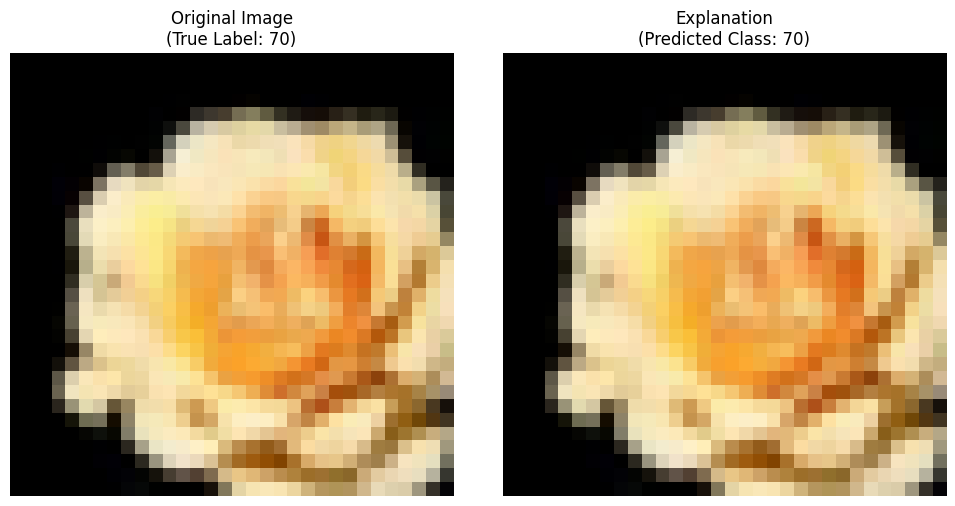

  0%|          | 0/1000 [00:00<?, ?it/s]

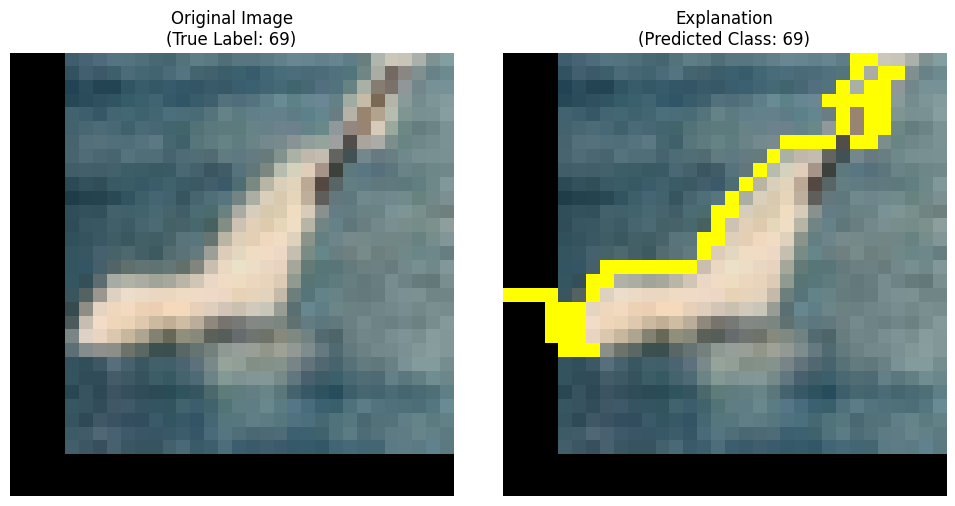

  0%|          | 0/1000 [00:00<?, ?it/s]

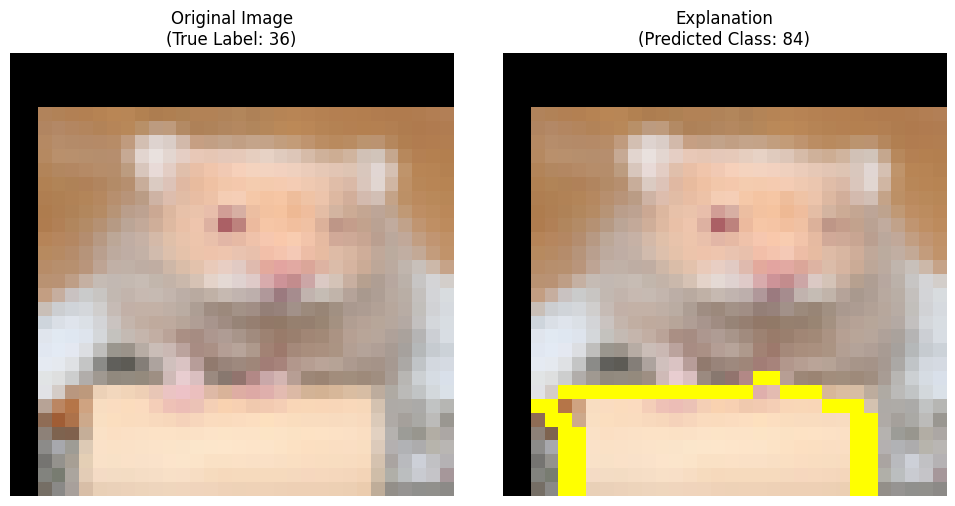

  0%|          | 0/1000 [00:00<?, ?it/s]

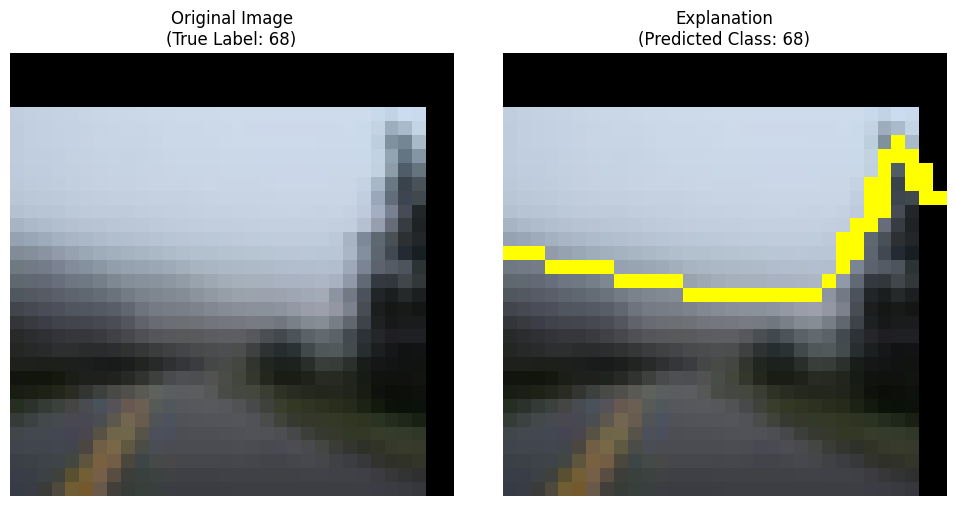

In [ ]:
images = [93, 20, 59, 890, 342]

for i in images:

  image_tensor, label = testset[i]
  image_np = image_tensor.numpy().transpose(1, 2, 0)


  explanation = explainer.explain_instance(
      image_np,
      predict,
      top_labels=5,
      hide_color=0,
      num_samples=1000
  )

  temp, mask = explanation.get_image_and_mask(
      explanation.top_labels[0],
      positive_only=True,
      hide_rest=False
  )


  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  axes[0].imshow((image_np * 0.5 + 0.5))  # Denormalize for visualization
  axes[0].axis('off')
  axes[0].set_title(f"Original Image\n(True Label: {label})")

  axes[1].imshow(mark_boundaries(temp * 0.5 + 0.5, mask))
  axes[1].axis('off')
  axes[1].set_title(f"Explanation\n(Predicted Class: {explanation.top_labels[0]})")

  plt.tight_layout()
  plt.show()